### _Imports_

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles

import seaborn as sns
import matplotlib.pylab as plt

pd.set_option('display.max_columns', None)

## 1. Dataset Exploration

### 1.1 High-level overview

In [4]:
df = pd.read_csv('../data/Sample - Superstore.csv', encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [12]:
# Nulls and data types

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

Observations:
    
- There are no nulls
- Order Date and Ship Date are in 'object' format. We need to change them to 'datetime'

In [11]:
# Changing the dates to 'datetime' data type:

df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])


# Checking the outcome:

#df.info()

In [18]:
# Numerical variables

df.describe()

,Row ID,Order Date,Ship Date,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994,9994,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2016-04-30 00:07:12.259355648,2016-05-03 23:06:58.571142912,55190.379428,229.858001,3.789574,0.156203,28.656896
min,1.000000,2014-01-03 00:00:00,2014-01-07 00:00:00,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,2015-05-23 00:00:00,2015-05-27 00:00:00,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,2016-06-26 00:00:00,2016-06-29 00:00:00,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,2017-05-14 00:00:00,2017-05-18 00:00:00,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,2017-12-30 00:00:00,2018-01-05 00:00:00,99301.000000,22638.480000,14.000000,0.800000,8399.976000
std,2885.163629,NaN,NaN,32063.693350,623.245101,2.225110,0.206452,234.260108


In [20]:
num_vars = list(df.describe().columns)

Observations:

- Minimum sales are 0.44$, we need to check whether it makes sense in business context
- Quantities are integers, which is a good sign
- Discount varies between 0% and 80%, this also makes sense
- Profit might be negative. This might occure when the costs are higher than sales. This can be related to high discounts. We will need to double-check the rows with negative profit later.

In [13]:
# Categorical variables

In [14]:
# Defining a function for visualization:

def cat_var(df, cols):
    '''
    Return: a Pandas dataframe object with the following columns:
        - "categorical_variable" => every categorical variable include as an input parameter (string).
        - "number_of_possible_values" => the amount of unique values that can take a given categorical variable (integer).
        - "values" => a list with the posible unique values for every categorical variable (list).

    Input parameters:
        - df -> Pandas dataframe object: a dataframe with categorical variables.
        - cols -> list object: a list with the name (string) of every categorical variable to analyse.
    '''
    cat_list = []
    for col in cols:
        cat = df[col].unique()
        cat_num = len(cat)
        cat_dict = {"categorical_variable":col,
                    "number_of_possible_values":cat_num,
                    "values":cat}
        cat_list.append(cat_dict)
    df = pd.DataFrame(cat_list).sort_values(by="number_of_possible_values", ascending=False)
    return df.reset_index(drop=True)

In [117]:
# Defining the list of categorical variables

cat_vars = [col for col in df.columns if col not in num_vars]
cat_vars

['Order ID',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Shipping Days']

In [118]:
# Applying the function for visualization

df_cat_vars = cat_var(df, cat_vars)
df_cat_vars

,categorical_variable,number_of_possible_values,values
0,Order ID,5009,"[CA-2016-152156, CA-2016-138688, US-2015-108966, CA-2014-115812, CA-2017-114412, CA-2016-161389,..."
1,Product ID,1862,"[FUR-BO-10001798, FUR-CH-10000454, OFF-LA-10000240, FUR-TA-10000577, OFF-ST-10000760, FUR-FU-100..."
2,Product Name,1850,"[Bush Somerset Collection Bookcase, Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back,..."
3,Customer ID,793,"[CG-12520, DV-13045, SO-20335, BH-11710, AA-10480, IM-15070, HP-14815, PK-19075, AG-10270, ZD-21..."
4,Customer Name,793,"[Claire Gute, Darrin Van Huff, Sean O'Donnell, Brosina Hoffman, Andrew Allen, Irene Maddox, Haro..."
5,City,531,"[Henderson, Los Angeles, Fort Lauderdale, Concord, Seattle, Fort Worth, Madison, West Jordan, Sa..."
6,State,49,"[Kentucky, California, Florida, North Carolina, Washington, Texas, Wisconsin, Utah, Nebraska, Pe..."
7,Sub-Category,17,"[Bookcases, Chairs, Labels, Tables, Storage, Furnishings, Art, Phones, Binders, Appliances, Pape..."
8,Shipping Days,8,"[3, 4, 7, 5, 2, 6, 1, 0]"
9,Ship Mode,4,"[Second Class, Standard Class, First Class, Same Day]"


Observations:

- There are 1850 products. Product ID and Product Name don't match as we already saw in poc_normalized_data_model.ipynb.
- Customer ID and Customer Name have the same number of entries which makes sense
- The number of States is consistent

### 1.2 Deep dive categorical variables

Lets have a closer look at products data

In [29]:
# Product Sub-Categories

df['Sub-Category'].unique()

array(['Bookcases', 'Chairs', 'Labels', 'Tables', 'Storage',
       'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances', 'Paper',
       'Accessories', 'Envelopes', 'Fasteners', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

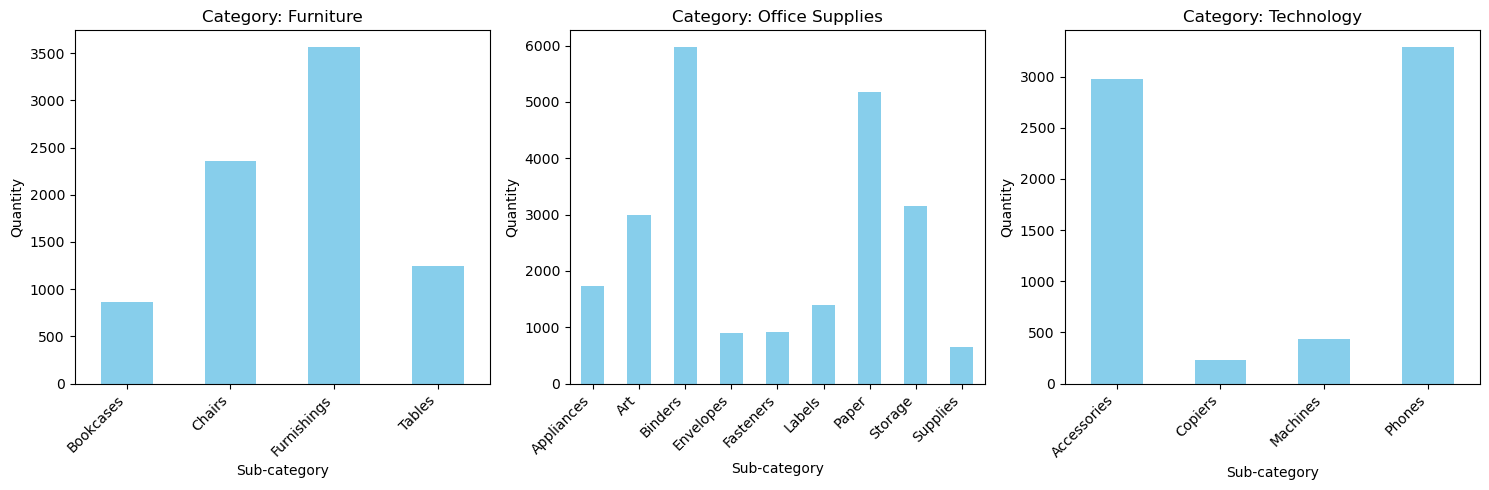

In [47]:
# Product Sub-categories by Category

categories = df['Category'].unique()

plt.figure(figsize=(15, 5))

for i, category in enumerate(categories, start=1):
    plt.subplot(1, 3, i)
    
    category_data = df[df['Category'] == category]
    
    qty_by_subcategory = category_data.groupby('Sub-Category')['Quantity'].sum()
    
    qty_by_subcategory.plot(kind='bar', color='skyblue')
    
    plt.title(f'Category: {category}')
    plt.xlabel('Sub-category')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Observation: each sub-category belongs to one category

In [54]:
# Product Names by Sub-category
'''
sub_categories = df['Sub-Category'].unique()

for i, sub_category in enumerate(sub_categories, start=1):
    
    sub_category_data = df[df['Sub-Category'] == sub_category]
    
    qty_by_sub_category = sub_category_data.groupby('Product Name')['Quantity'].sum()
    
    print(sub_category, '\n', qty_by_sub_category, '\n')
'''

In [60]:
# Product Counts by Sub-category

sub_categories = df['Sub-Category'].unique()

sub_category_product_dict = {}

for sub_category in sub_categories:
    
    sub_category_data = df[df['Sub-Category'] == sub_category]
    
    unique_products_count = sub_category_data['Product Name'].nunique()
    
    sub_category_product_dict[sub_category] = unique_products_count
    
sub_category_product_df = pd.DataFrame(list(sub_category_product_dict.items()), columns=['Sub-Category', 'Unique Products Count'])

print(sub_category_product_df)

   Sub-Category  Unique Products Count
0     Bookcases                     50
1        Chairs                     88
2        Labels                     70
3        Tables                     56
4       Storage                    132
5   Furnishings                    186
6           Art                    157
7        Phones                    189
8       Binders                    211
9    Appliances                     97
10        Paper                    277
11  Accessories                    147
12    Envelopes                     44
13    Fasteners                     34
14     Supplies                     36
15     Machines                     63
16      Copiers                     13


Additionally, lets investigate whether Product Categories are linked to Customer Segment.

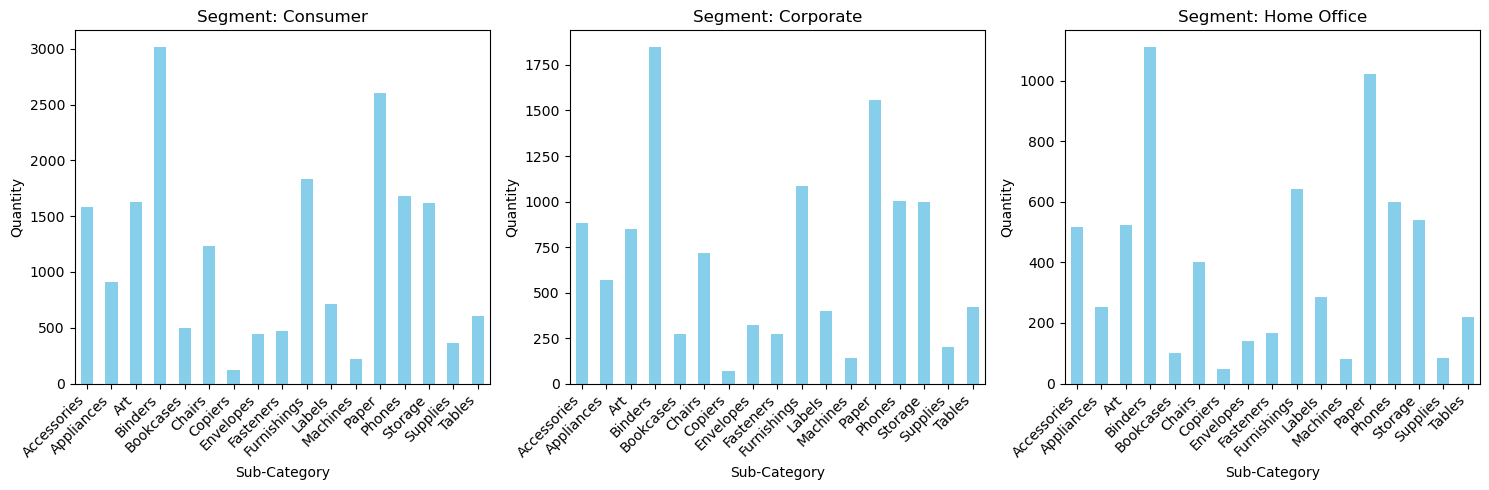

In [135]:
# Product Category by Segment

segments = df['Segment'].unique()

plt.figure(figsize=(15, 5))

for i, segment in enumerate(segments, start=1):
    plt.subplot(1, 3, i)
    
    segment_data = df[df['Segment'] == segment]
    
    qty_by_segment = segment_data.groupby('Sub-Category')['Quantity'].sum()
    
    qty_by_segment.plot(kind='bar', color='skyblue')
    
    plt.title(f'Segment: {segment}')
    plt.xlabel('Sub-Category')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Observation: each Segment buys full product portfolio. The distribution by product sub-category is very similar across Segments, which might indicate that this data is syntetic.

Now lets understand what is the meaning of the variables Ship Mode. For this we will calculate **shipping days** as the difference between Order Date and Ship Date.

In [61]:
df['Ship Mode'].unique()

array(['Second Class', 'Standard Class', 'First Class', 'Same Day'],
      dtype=object)

In [77]:
df['Shipping Days'] = df['Ship Date'] - df['Order Date']

df['Shipping Days'] = df['Shipping Days'].dt.days

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Days
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,3
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.9400,3,0.00,219.5820,3
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.6200,2,0.00,6.8714,4
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,7
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,7


In [79]:
df['Shipping Days'].unique()

array([3, 4, 7, 5, 2, 6, 1, 0], dtype=int64)

In [83]:
# Overview of product Sub-categories and Product Counts

ship_mode = df['Ship Mode'].unique()

ship_mode_dict = {}

for i in ship_mode:
    
    ship_mode_data = df[df['Ship Mode'] == i]
    
    ship_days = ship_mode_data['Shipping Days'].unique()
    
    ship_mode_dict[i] = ship_days
    
ship_mode_df = pd.DataFrame(list(ship_mode_dict.items()), columns=['Ship Mode', 'Shipping Days'])

In [81]:
ship_mode_df

,Ship Mode,Shipping Days
0,Second Class,"[3, 4, 2, 5, 1]"
1,Standard Class,"[7, 5, 4, 6, 3]"
2,First Class,"[2, 1, 3, 4]"
3,Same Day,"[0, 1]"


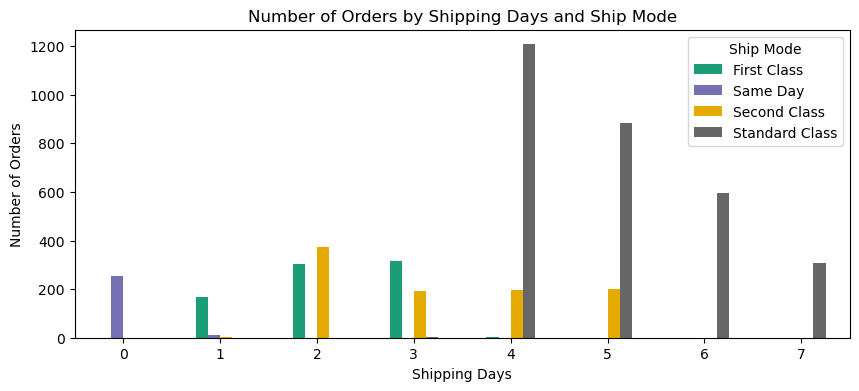

In [113]:
# Number of orders by ship mode and shipping days

order_counts = df.groupby(['Ship Mode', 'Shipping Days'])['Order ID'].nunique().reset_index()

order_counts_pivot = order_counts.pivot(index='Shipping Days', columns='Ship Mode', values='Order ID')

order_counts_pivot.plot(kind='bar', figsize=(10, 4), cmap='Dark2')

plt.title('Number of Orders by Shipping Days and Ship Mode')
plt.xlabel('Shipping Days')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)
plt.legend(title='Ship Mode')

plt.show()

CONCLUSION: Shipping days by ship mode

- Same Day: 0 days
- First Class: 1-3 days
- Second Class: 2-5 days
- Standard Class: 4-7 days

Note: there is a small number of orders that doesn't follow these rules, but it might be because of the way how we calculate shipping days. Since we don't have precise order time, it might be, for example, that the order with 'Same Day' ship mode is placed today in the evening and shipped within the next 24 hours, which is the day after. In that case our feature 'Shipping Days' will be 1, but the order has been shipped in time.

### 1.3 Data Interpretation

After this initial exploration, we have better understanding of each variable in our dataset.

| Name        | Type   | Unique Values | Description | Transformations | To Does |
|------------------|-----------------|---------------|------------------|-----------------|---------|
| Row ID           | Numerical       | 9994 | Unique identifier for each order item |  |  |
| Order ID         | Categorical     | 5009 | Unique identifier for each order |  |  |
| Order Date       | Date            | 1237 | Date when the order was placed | Converted to datetime |  |
| Ship Date        | Date            | 1334 | Date when the order was shipped | Converted to datetime |  |
| Ship Mode        | Categorical     | 4 | Delivery time: Same Day (0 days), First Class (1-3 days), Second Class (2-5 days), Standard Class (4-7 days) |  |  |
| Customer ID      | Categorical     | 793 | Unique identifier for each customer |  |  |
| Customer Name    | Categorical     | 793 | Full name of the customer |  | Create a new feature, Gender |
| Segment          | Categorical     | 3 | Market segment of the customer: Consumer, Corporate, Home Office |  |  |
| Country          | Categorical     | 1 | United States |  |  |
| City             | Categorical     | 531 | City where the order was placed |  | Replace city by San Diego for postal code 92024|
| State            | Categorical     | 49 | State where the order was placed |  |  |
| Postal Code      | Categorical     | 631 | Postal code where the order was placed |  |  |
| Region           | Categorical     | 4 | Region where the order was placed: South, West, Central, East |  |  |
| Product ID       | Categorical     | 1862 | Product identifier |  | Data exploration revealed that Product ID is not unique. Solution: create a syntetic product ID |
| Category         | Categorical     | 3 | High-level product classification: Furniture, Office Supplies, Technology |  |  |
| Sub-Category     | Categorical     | 17 | Specific classification within a category (e.g. Bookcases, Chairs, Labels, Tables, Storage, ...  |  |  |
| Product Name     | Categorical     | 1850 | Name of the product |  |  |
| Sales            | Numerical       | na | Sales amount for the product |  | Check data quality (e.g. sales of 0.44$). Calculate Original Selling Price (OSP) and Average Selling Price (ASP). Check whether OSP is unique for each product  |
| Quantity         | Numerical       | na | Quantity of the product sold |  |  |
| Discount         | Numerical       | na | Discount applied to the sale |  |  |
| Profit           | Numerical       | na | Profit made on the product |  | Check data quality (e.g. negative profit). Calculate Cost = Profit - OSP * Quantity. Check uniqueness for each product |

na = not applicable
